# Assigning Vibes to Songs

This notebook aims to conduct Latent Dirichlet Allocation to identify terms associated with underlying topics in textual data from Spotify.

In [1]:
import pandas as pd
import numpy as np
import gensim.corpora as corpora 
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import re
import requests
import json
from hidden import OpenAI_api_key
import pickle 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/austineck/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## LDA Approaches
Note: to aid with creating visualizations the lists of these scores will be saved out as a pickle file in order to access the results quickly. 
### Approach 1: Just Playlist Names

In [2]:
df = pd.read_csv("playlist_info1.csv")
df.head()
documents = df.name.to_list()
stop_words = stopwords.words('english')

texts = [[word for word in str(doc).split(" ") if word not in stop_words and word not in string.punctuation] for doc in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
df.head()

,Unnamed: 0,playlist_id,description,image,name
0,0,3NRoLDaBAinoLTmVHNMGjP,WHDT 2024,https://mosaic.scdn.co/640/ab67616d00001e0226f...,If I Could Turn Back Time
1,1,4d8ifq5Pj9CLLox1W1g73s,Playlist transferred with SongShift,https://mosaic.scdn.co/640/ab67616d00001e02233...,Tapestry of Fire & Rain
2,2,1tqaQNAzYfo17m5pJLAzq2,An international showcase of up-and-coming mal...,https://image-cdn-ak.spotifycdn.com/image/ab67...,Orpheus — Male Singers and Vocalists
3,3,1cbhtfusP7Z6Yxxs8BYabc,"Jazz, soul, r&amp;b, funk, roots rock &amp; more!",https://image-cdn-ak.spotifycdn.com/image/ab67...,~A Little Bit of Soul~
4,4,3xLpkdGJrWrKHZy7ME0MLQ,FEATURED ARTIST: Taylor Austin Dye. The freshe...,https://image-cdn-ak.spotifycdn.com/image/ab67...,Country (Girl Gang Music)


In [3]:
overall_best_score = -999
overall_best_model = None

just_names_scores = []
best_score = -999
just_names_best_model = None
best_n_topics = 0

for n_topics in tqdm(range(1,51)):
  if n_topics < 5:
    just_names_scores.append(np.nan)
    continue

  model = LdaModel(corpus=corpus, id2word=id2word, num_topics=n_topics, passes=10, alpha="auto", random_state=42)
  coherence = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence="c_v")
  score = coherence.get_coherence()
  just_names_scores.append(score)
  if score >= best_score:
    just_names_best_model = deepcopy(model)
    best_score = score
    best_n_topics = n_topics

  if score >= overall_best_score:
    overall_best_score = score
    overall_best_model = deepcopy(model)

print("\n"+str(best_n_topics))
with open("just_names.pkl", "wb") as fname: 
  pickle.dump(just_names_scores, fname)

100%|██████████| 50/50 [10:19<00:00, 12.40s/it]


29


### Approach 2: Name & Description

In [5]:
df["Name + Description"] = df.name + " " + df.description.fillna("")
df["Name + Description"] = df["Name + Description"].str.strip()

documents = df["Name + Description"].to_list()

name_des_scores = []
best_score = -999
name_des_best_model = None
best_n_topics = 0

texts = [[word for word in str(doc).split(" ") if word not in stop_words and word not in string.punctuation] for doc in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

for n_topics in tqdm(range(1,51)):
  if n_topics < 5:
    name_des_scores.append(np.nan)
    continue

  model = LdaModel(corpus = corpus, id2word=id2word, num_topics=n_topics, passes=10, alpha="auto", random_state=42)
  coherence = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence="c_v")
  score = coherence.get_coherence()
  name_des_scores.append(score)
  if score >= best_score:
    best_score = score
    name_des_best_model = deepcopy(model)
    best_n_topics = n_topics


  if score >= overall_best_score:
    overall_best_score = score
    overall_best_model = deepcopy(model)

print("\n"+str(best_n_topics))
with open("name_des.pkl", "wb") as fname: 
  pickle.dump(name_des_scores, fname)

100%|██████████| 50/50 [13:05<00:00, 15.71s/it]


24


### Approach 3: Name + Description + Song Titles

In [6]:
#read data source with genre information
songs = pd.read_csv("datawithgenres.csv").drop(columns = ["Unnamed: 0"])

#create a column with a list of track names of each playlist then convert is to string. Finally, concat with name & description.
df["tracks"] = df.playlist_id.apply(lambda x: songs[songs["playlist_id"] == x].track_name.to_list())
df["tracks1"] = df.tracks.apply(lambda x: " ".join(x))
df["Name + Description + Tracks"] = df["Name + Description"] + " " + df["tracks1"]
documents = df["Name + Description + Tracks"].to_list()

name_track_scores = []
best_score = -999
best_n_topics = 0
name_track_best_model = None

texts = [[word for word in str(doc).split(" ") if word not in stop_words and word not in string.punctuation] for doc in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

for n_topics in tqdm(range(1,51)): #unlikely to see improved performance beyond 50 clusters
  if n_topics < 5:
      name_track_scores.append(np.nan)
      continue

  model = LdaModel(corpus = corpus, id2word=id2word, num_topics=n_topics, passes=10, alpha="auto", random_state=42)
  coherence = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence="c_v")
  score = coherence.get_coherence()
  name_track_scores.append(score)
  if score >= best_score:
    best_score = score
    name_track_best_model = deepcopy(model)
    best_n_topics = n_topics


  if score >= overall_best_score:
    overall_best_score = score
    overall_best_model = deepcopy(model)

print("\n"+str(best_n_topics))
with open("name_desc_tracks.pkl", "wb") as fname: 
  pickle.dump(name_track_scores, fname)

100%|██████████| 50/50 [29:38<00:00, 35.56s/it]


8


### Approach 4: Name + Genre

In [7]:
songs = pd.read_csv("datawithgenres.csv").drop(columns = ["Unnamed: 0"])

df['genres'] = df.playlist_id.apply(lambda x: [str(y) for y in set(songs[songs["playlist_id"] == x].top_genre)])

df["genre_str"] = df.genres.apply(lambda x: " ".join(x))
df["Name + Genre"] = df["name"] + " " + df["genre_str"]

documents = df["Name + Genre"].to_list()

name_genre_scores = []
best_score = -999
best_n_topics = 0
name_genre_best_model = None

texts = [[word for word in str(doc).split(" ") if word not in stop_words and word not in string.punctuation] for doc in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

for n_topics in tqdm(range(1,51)): #unlikely to see improved performance beyond 50 clusters
  if n_topics < 5:
    name_genre_scores.append(np.nan)
    continue
  model = LdaModel(corpus = corpus, id2word=id2word, num_topics=n_topics, passes=10, alpha="auto", random_state=42)
  coherence = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence="c_v")
  score = coherence.get_coherence()
  name_genre_scores.append(score)
  if score >= best_score:
    best_score = score
    name_genre_best_model = deepcopy(model)
    best_n_topics = n_topics


  if score >= overall_best_score:
    overall_best_score = score
    overall_best_model = deepcopy(model)

print("\n"+str(best_n_topics))
with open("name_genre.pkl", "wb") as fname: 
  pickle.dump(name_genre_scores, fname)

100%|██████████| 50/50 [18:00<00:00, 21.60s/it]


6


### Comparison Plot

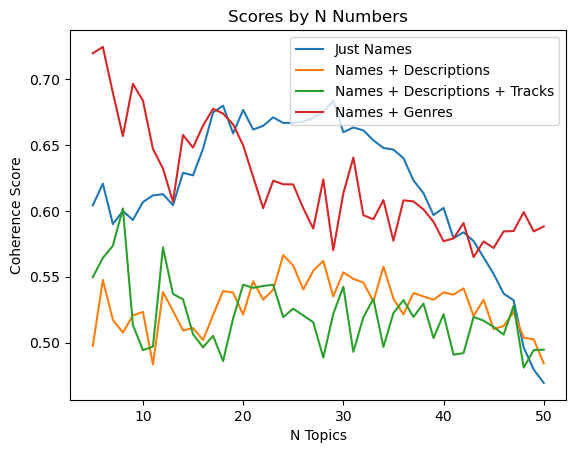

In [9]:
x = np.arange(1,51)

def load_pickle(fname): 
  with open(fname, "rb") as fname: 
    return pickle.load(fname)
  
just_names_scores = load_pickle("just_names.pkl")
name_des_scores = load_pickle("name_des.pkl")
name_track_scores = load_pickle("name_desc_tracks.pkl")
name_genre_scores = load_pickle("name_genre.pkl")

plt.plot(x, just_names_scores, label = "Just Names")
plt.plot(x, name_des_scores, label = "Names + Descriptions")
plt.plot(x, name_track_scores, label = "Names + Descriptions + Tracks")
plt.plot(x, name_genre_scores, label = "Names + Genres")
plt.title("Scores by N Numbers")
plt.ylabel("Coherence Score")
plt.xlabel("N Topics")
plt.legend()
plt.show()

In [ ]:
name_genre_best_model.show_topics(num_topics = -1, num_words = 5)

[(0,
  '0.073*"jazz" + 0.043*"nan" + 0.028*"–" + 0.015*"contemporary" + 0.014*"The"'),
 (1,
  '0.093*"pop" + 0.051*"rock" + 0.039*"indie" + 0.036*"classic" + 0.032*"country"'),
 (2,
  '0.119*"pop" + 0.054*"house" + 0.040*"dance" + 0.030*"spanish" + 0.026*"rock"'),
 (3,
  '0.088*"rock" + 0.088*"indie" + 0.086*"pop" + 0.049*"alternative" + 0.026*"dance"'),
 (4, '0.157*"hip" + 0.153*"hop" + 0.086*"rap" + 0.033*"r&b" + 0.022*"atl"'),
 (5,
  '0.194*"pop" + 0.068*"latin" + 0.031*"hip" + 0.030*"hop" + 0.029*"dance"')]

In [ ]:
just_names_best_model.show_topics(num_topics=-1, num_words=5)

[(0,
  '0.223*"Miguel" + 0.126*"Music" + 0.060*"Days" + 0.046*"2" + 0.006*"chill"'),
 (1, '0.140*"Hits" + 0.034*"Jazz" + 0.033*"la" + 0.012*"Film" + 0.012*"🔥"'),
 (2,
  '0.118*"My" + 0.039*"Tracks" + 0.029*"Shazam" + 0.015*"Gang" + 0.012*"Top"'),
 (3, '0.192*"2023" + 0.010*"John" + 0.010*"rap" + 0.009*"hip" + 0.009*"Las"'),
 (4, '0.116*"Playlist" + 0.089*"A" + 0.066*"el" + 0.062*"(2)" + 0.025*"Rock"'),
 (5,
  '0.056*"New" + 0.024*"Indie" + 0.024*"De" + 0.017*"Alternative" + 0.013*"Abigail"'),
 (6,
  '0.305*"–" + 0.063*"Música" + 0.054*"Navidad" + 0.024*"Various" + 0.023*"Artists"'),
 (7, '0.257*"The" + 0.048*"Of" + 0.024*"In" + 0.022*"Black" + 0.021*"90s"'),
 (8, '0.091*"2019" + 0.074*"Take" + 0.031*"El" + 0.022*"del" + 0.022*"For"'),
 (9,
  '0.106*"Summer" + 0.064*"Songs" + 0.026*"R&B" + 0.017*"One" + 0.014*"Back"'),
 (10,
  '0.061*"Top" + 0.055*"—" + 0.041*"playlist" + 0.030*"Songs" + 0.030*"Your"'),
 (11,
  '0.107*"Best" + 0.075*"2014" + 0.075*"Jamz" + 0.014*"Soundtrack)" + 0.013*"B

### Take LDA Outputs and give to ChatGPT API to assign vibes.

In [8]:
df = pd.read_csv("playlist_info1.csv")
stop_words = stopwords.words('english')

id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

df["Name + Description"] = df.name + " " + df.description.fillna("")
df["Name + Description"] = df["Name + Description"].str.strip()

songs = pd.read_csv("datawithgenres.csv").drop(columns = ["Unnamed: 0"])
df["tracks"] = df.playlist_id.apply(lambda x: songs[songs["playlist_id"] == x].track_name.to_list())
df["tracks1"] = df.tracks.apply(lambda x: " ".join(x))
df["Name + Description + Tracks"] = df["Name + Description"] + " " + df["tracks1"]
df['genres'] = df.playlist_id.apply(lambda x: [str(y) for y in set(songs[songs["playlist_id"] == x].top_genre)])
df["genre_str"] = df.genres.apply(lambda x: " ".join(x))
df["genre_str"] = df.genre_str.str.replace("nan", "")
df["Name + Genre"] = df["name"] + " " + df["genre_str"]

documents = df["Name + Genre"].to_list()
texts = [[word for word in str(doc).split(" ") if word not in stop_words and word not in string.punctuation] for doc in documents]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

model = LdaModel(corpus = corpus, id2word=id2word, num_topics=15, passes=10, alpha="auto", random_state=42)
coherence = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence="c_v")

In [9]:
pat="[\d\.]+?\*\"(?P<term1>.+?)\"\s\+\s[\d\.]+?\*\"(?P<term2>.+?)\"\s\+\s[\d\.]+?\*\"(?P<term3>.+?)\"\s\+\s[\d\.]+?\*\"(?P<term4>.+?)\"\s\+\s[\d\.]+?\*\"(?P<term5>.+)\""
for i, results in model.show_topics(num_topics = -1, num_words=5):
  m = re.match(pat, results)
  print(",".join(m.groupdict().values()))

lo-fi,chillhop,beats,greek,japanese
country,pop,classic,canadian,contemporary
pop,latin,spanish,dance,arena
indie,pop,rock,alternative,dance
soundtrack,orchestral,ambient,trap,Música
Marta,canario,folklore,alt,z
music,bass,speedrun,dubstep,experimental
hip,hop,rap,r&b,pop
house,pop,dance,edm,deep
cumbia,musica,rock,cantautor,mexican
jazz,blues,folk,soul,contemporary
house,trance,dance,progressive,deep
pop,r&b,indie,neo,contemporary
pop,–,The,alternative,brostep
rock,pop,classic,adult,standards


In [10]:
tops = []
for cor in corpus:
  distro = model.get_document_topics(cor)
  topic_id = max(distro, key = lambda x: x[1])[0]
  topics = ",".join([x[0] for x in model.show_topic(topic_id)])
  tops.append(topics)

df["Topics"] = tops

In [12]:
vibe1 = []
vibe2 = []
vibe3 = []

url = "https://api.openai.com/v1/chat/completions"
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {OpenAI_api_key}"
}

total_tokens = 0

for topic, tracks in tqdm(zip(df.Topics.to_list(), df.tracks1.to_list())):
  params = {
    "model": "gpt-4o-mini",
    "messages": [
        {"role": "system", "content":
          """You are being given two pieces of information related to a spotify playlist. The first are the most important topics found by LDA.
          The second piece is a track listing of songs on the playlist. They are seperated by a pipe operator. You should return three moods or vibes you think are associated with this.
          Send the vibes only and separate them with the pipe. vibes should be one word."""},
        {"role": "user", "content": f"{topic} | {tracks}"}
    ]
  }

  response = requests.post(url, data=json.dumps(params), headers=headers)
  failures = 0
  while response.status_code != 200:
    print(f"Bad status code. {response.status_code}. {topic[:25]} | {tracks[:25]}")
    if failures < 10:
      response = requests.post(url, data=json.dumps(params), headers=headers)
      failures += 1
    else:
      raise RuntimeError("10 failures. Quiting... ")

  response = json.loads(response.text)


  vibes = response["choices"][0]["message"]["content"].split("|")
  tokens = response["usage"]["total_tokens"]
  vibe1.append(vibes[0].strip())
  vibe2.append(vibes[1].strip())
  vibe3.append(vibes[2].strip())



6it [00:03,  1.54it/s]


KeyboardInterrupt: 

In [ ]:
df["vibe1"] = vibe1
df["vibe2"] = vibe2
df["vibe3"] = vibe3

df.to_csv("playlist_vibes.csv", index=False)

In [ ]:
df.head()

,Unnamed: 0,playlist_id,description,image,name,Name + Description,tracks,tracks1,Name + Description + Tracks,genres,genre_str,Name + Genre,Topics,vibe1,vibe2,vibe3
0,0,3NRoLDaBAinoLTmVHNMGjP,WHDT 2024,https://mosaic.scdn.co/640/ab67616d00001e0226f...,If I Could Turn Back Time,If I Could Turn Back Time WHDT 2024,"[Lucky Star, Material Girl, Crazy for You, Int...",Lucky Star Material Girl Crazy for You Into th...,If I Could Turn Back Time WHDT 2024 Lucky Sta...,"[album rock, east coast hip hop, disco, folk, ...",album rock east coast hip hop disco folk soft ...,If I Could Turn Back Time album rock east coa...,"rock,pop,classic,adult,standards,dance,soul,al...",nostalgic,upbeat,joyful
1,1,4d8ifq5Pj9CLLox1W1g73s,Playlist transferred with SongShift,https://mosaic.scdn.co/640/ab67616d00001e02233...,Tapestry of Fire & Rain,Tapestry of Fire & Rain Playlist transferred ...,"[Carolina in My Mind, Home Again, (You Make Me...",Carolina in My Mind Home Again (You Make Me Fe...,Tapestry of Fire & Rain Playlist transferred ...,"[classic rock, brill building pop]",classic rock brill building pop,Tapestry of Fire & Rain classic rock brill bu...,"rock,pop,classic,adult,standards,dance,soul,al...",nostalgic,soothing,uplifting
2,2,1tqaQNAzYfo17m5pJLAzq2,An international showcase of up-and-coming mal...,https://image-cdn-ak.spotifycdn.com/image/ab67...,Orpheus — Male Singers and Vocalists,Orpheus — Male Singers and Vocalists An intern...,"[Midnight Rain, Willow, Parallel Universe, Nev...",Midnight Rain Willow Parallel Universe Never i...,Orpheus — Male Singers and Vocalists An intern...,"[indie pop rap, gen z singer-songwriter, nan, ...",indie pop rap gen z singer-songwriter pop fol...,Orpheus — Male Singers and Vocalists indie pop...,"indie,pop,rock,alternative,dance,modern,soul,b...",dreamy,reflective,nostalgic
3,3,1cbhtfusP7Z6Yxxs8BYabc,"Jazz, soul, r&amp;b, funk, roots rock &amp; more!",https://image-cdn-ak.spotifycdn.com/image/ab67...,~A Little Bit of Soul~,"~A Little Bit of Soul~ Jazz, soul, r&amp;b, fu...","[It's Only A Paper Moon, What A Wonderful Worl...",It's Only A Paper Moon What A Wonderful World ...,"~A Little Bit of Soul~ Jazz, soul, r&amp;b, fu...","[adult standards, dixieland, nan, avant-garde ...",adult standards dixieland avant-garde jazz cl...,~A Little Bit of Soul~ adult standards dixiela...,"jazz,blues,folk,soul,contemporary,classical,in...",nostalgic,soulful,contemplative
4,4,3xLpkdGJrWrKHZy7ME0MLQ,FEATURED ARTIST: Taylor Austin Dye. The freshe...,https://image-cdn-ak.spotifycdn.com/image/ab67...,Country (Girl Gang Music),Country (Girl Gang Music) FEATURED ARTIST: Tay...,"[Southern Accents, Diamonds & Rhinestones, I T...",Southern Accents Diamonds & Rhinestones I Trie...,Country (Girl Gang Music) FEATURED ARTIST: Tay...,"[modern country pop, nashville indie, contempo...",modern country pop nashville indie contemporar...,Country (Girl Gang Music) modern country pop n...,"country,pop,classic,canadian,contemporary,texa...",nostalgic,carefree,bittersweet


To limit the number of topics for users to select, we're going to limit the options to the top 25.

In [ ]:
top25 = pd.concat([df["vibe1"], df["vibe2"], df["vibe3"]]).value_counts()[:25].index.to_list()

In [ ]:
df.drop(columns=["vibe1", "vibe2", "vibe3"], inplace=True)

In [ ]:
from time import sleep

df = pd.read_csv("/content/playlist_vibes.csv")

vibe1 = []
vibe2 = []
vibe3 = []

url = "https://api.openai.com/v1/chat/completions"
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {OpenAI_api_key}"
}

total_tokens = 0

for topic, tracks in tqdm(zip(df.Topics.to_list(), df.tracks1.to_list())):
  params = {
    "model": "gpt-4o-mini",
    "messages": [
        {"role": "system", "content":
          f"""You are being given two pieces of information related to a spotify playlist. The first are the most important topics found by LDA.
          The second piece is a track listing of songs on the playlist. They are seperated by a pipe operator.
          Pick the vibes from the following list:
          {top25}
          You should return three moods or vibes you think are associated with this.
          Send the vibes only and separate them with the pipe. vibes should be one word."""},
        {"role": "user", "content": f"{topic} | {tracks}"}
    ]
  }

  response = requests.post(url, data=json.dumps(params), headers=headers)

  failures = 0
  while response.status_code != 200:
    print(f"Bad status code. {response.status_code}. {topic[:25]} | {tracks[:25]}")
    failures += 1

    if response.status_code == 429:
      print("Sleeping")
      sleep(60)

    if failures < 10:
      response = requests.post(url, data=json.dumps(params), headers=headers)
    else:
      raise RuntimeError("10 failures. Quiting... ")

  response = json.loads(response.text)
  vibes = response["choices"][0]["message"]["content"].split("|")
  tokens = response["usage"]["total_tokens"]
  vibe1.append(vibes[0].strip())
  vibe2.append(vibes[1].strip())
  vibe3.append(vibes[2].strip())

df["vibe1"] = vibe1
df["vibe2"] = vibe2
df["vibe3"] = vibe3
df.to_csv("playlist_vibes_top25.csv")

df.head()

7it [00:03,  2.15it/s]

Bad status code. 429. pop,latin,spanish,dance,a | Me Gustas Imán Perdió Est
Sleeping


14it [01:07,  2.71s/it]

Bad status code. 429. jazz,blues,folk,soul,cont | Beast Of Burden - Remaste
Sleeping


22it [02:14,  2.64s/it]

Bad status code. 429. rock,pop,classic,adult,st | Psycho (feat. Ty Dolla $i
Sleeping


30it [03:19,  2.19s/it]

Bad status code. 429. pop,r&b,indie,neo,contemp | Mama Said Can't You See F
Sleeping


37it [04:22,  2.82s/it]

Bad status code. 429. rock,pop,classic,adult,st | Katie Dear The Lighthouse
Sleeping


45it [05:28,  2.28s/it]

Bad status code. 429. jazz,blues,folk,soul,cont | Seven Spanish Angels (wit
Sleeping


52it [06:34,  3.09s/it]

Bad status code. 429. indie,pop,rock,alternativ | Sing to the Mountain Like
Sleeping


60it [07:38,  2.21s/it]

Bad status code. 429. pop,r&b,indie,neo,contemp | Smoke Signals Old Pine Co
Sleeping


67it [08:43,  2.85s/it]

Bad status code. 429. pop,–,The,alternative,bro | Once In My Life Cutting S
Sleeping


75it [09:47,  2.15s/it]

Bad status code. 429. indie,pop,rock,alternativ | Over Cold Little Heart - 
Sleeping


82it [10:51,  2.73s/it]

Bad status code. 429. rock,pop,classic,adult,st | Rocket Man (I Think It's 
Sleeping


89it [11:55,  2.88s/it]

Bad status code. 429. cumbia,musica,rock,cantau | I Should Live in Salt Dem
Sleeping


97it [12:59,  2.16s/it]

Bad status code. 429. indie,pop,rock,alternativ | Berlin Sunrise Yesterday 
Sleeping


104it [14:04,  2.81s/it]

Bad status code. 429. country,pop,classic,canad | Woman Northern Blues Mizz
Sleeping


112it [15:08,  2.17s/it]

Bad status code. 429. soundtrack,orchestral,amb | 10,000 Emerald Pools Dug 
Sleeping


119it [16:14,  2.94s/it]

Bad status code. 429. pop,r&b,indie,neo,contemp | Supermarket Flowers Tener
Sleeping


127it [17:18,  2.12s/it]

Bad status code. 429. rock,pop,classic,adult,st | Come Thou Fount Forever R
Sleeping


134it [18:22,  2.84s/it]

Bad status code. 429. pop,–,The,alternative,bro | Be Still My Soul Be Thou 
Sleeping


142it [19:27,  2.18s/it]

Bad status code. 429. Marta,canario,folklore,al | Y Closed (feat. Chad Laws
Sleeping


149it [20:32,  2.97s/it]

Bad status code. 429. indie,pop,rock,alternativ | I Was Made For Loving You
Sleeping


157it [21:36,  2.13s/it]

Bad status code. 429. pop,r&b,indie,neo,contemp | Slipping Through My Finge
Sleeping


164it [22:40,  2.78s/it]

Bad status code. 429. hip,hop,rap,r&b,pop,atl,a | Not Like Us MILLION DOLLA
Sleeping


171it [23:44,  2.87s/it]

Bad status code. 429. pop,r&b,indie,neo,contemp | Oops!...I Did It Again Um
Sleeping


179it [24:48,  2.23s/it]

Bad status code. 429. indie,pop,rock,alternativ | Lotus Flower Soul to Sque
Sleeping


179it [25:45,  8.63s/it]


KeyboardInterrupt: 

In [ ]:
df = pd.read_csv("/content/playlist_vibes_top25.csv")
songs_df = pd.read_csv("https://raw.githubusercontent.com/aeckumich/siads696_M2/main/data/complete_dataset.csv")
songs_df.head()

,song_id,track_name,artist_name,album_name,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,duration,tempo,time_signature,playlist_id
0,2hWI9GNr3kBrxZ7Mphho4Q,Lucky Star,Madonna,Madonna,56,0.803,0.814,4,-4.579,0,0.0381,0.1980,0.000012,0.2230,0.933,337840,117.080,4,3NRoLDaBAinoLTmVHNMGjP
1,7bkyXSi4GtVfD7itZRUR3e,Material Girl,Madonna,Like a Virgin,57,0.775,0.616,0,-12.676,1,0.0317,0.2460,0.000007,0.0511,0.980,240707,136.630,4,3NRoLDaBAinoLTmVHNMGjP
2,6iABG3ruJ1ArrulilbVhai,Crazy for You,Madonna,Something to Remember,47,0.667,0.712,9,-6.575,1,0.0294,0.1210,0.000000,0.1280,0.538,224520,95.009,4,3NRoLDaBAinoLTmVHNMGjP
3,2m0M7YqCy4lXfedh18qd8N,Into the Groove,Madonna,Celebration (double disc version),65,0.731,0.856,10,-4.164,0,0.0351,0.0664,0.008570,0.0691,0.805,285093,116.472,4,3NRoLDaBAinoLTmVHNMGjP
4,6ioBgySxoeQKALvAeLEmId,Express Yourself,Madonna,Celebration (double disc version),58,0.667,0.930,7,-4.585,1,0.0608,0.0108,0.000000,0.1760,0.893,239093,115.572,4,3NRoLDaBAinoLTmVHNMGjP


In [ ]:
final = pd.merge(songs_df, df[["playlist_id", "vibe1", "vibe2", "vibe3"]], on="playlist_id")

In [ ]:
final.to_csv("song_vibes.csv")

### Testing

In [ ]:
final.sample(10)

,song_id,track_name,artist_name,album_name,track_popularity,danceability,energy,key,loudness,mode,...,instrumentalness,liveness,valence,duration,tempo,time_signature,playlist_id,vibe1,vibe2,vibe3
22366,3sLYg4FenIvrnk4HG9vaBb,This what they want (MAKE WAVS 420 COMP),Rabbithole,This what they want (MAKE WAVS 420 COMP),1,0.710,0.458,8,-10.883,1,...,0.000000,0.1030,0.465,203754,132.119,4,3oeMziWiCpcCpWUocZKmbZ,energetic,experimental,vibrant
55249,36jjEFMzeDZWM3C5EpRxMg,Chocolate,Profetas,Baila,0,0.700,0.874,11,-3.877,0,...,0.000018,0.1020,0.962,217991,179.958,4,1cnNp4oNDH9ltLtpBONupV,joyful,romantic,energetic
88840,3kkJwuhd7JOvi0lcXPLIeV,Come Tiki Tam,Eleni Foureira,Vasilissa,20,0.707,0.933,8,-2.604,0,...,0.000129,0.3240,0.635,188112,98.027,4,6v6toPs0OHUzhp6mYPPP9W,upbeat,passionate,eclectic
55538,0uqvSVhGgQTIdj9G51vhvv,Finally,CeCe Peniston,Finally,63,0.791,0.658,7,-11.128,1,...,0.000000,0.0472,0.842,245000,120.066,4,1gzRasb2jZxbBAMyOIe42o,energetic,vibrant,nostalgic
85139,0LfJkvPNCNEMLpZJgDQiV1,The Wonder of You,Elvis Presley,The Essential Elvis Presley,61,0.448,0.691,7,-6.957,1,...,0.001110,0.9450,0.633,153200,88.836,4,59nmPZQAE0dX44OF6DXDcE,nostalgic,reflective,soulful
37590,6KbhhjGV786ijqNHhjHsBr,Bir Taş Attım Pencereye,İbrahim Tatlıses,Sizler Için,42,0.742,0.960,9,-4.677,0,...,0.000004,0.0674,0.816,267373,96.003,4,04eVmKvOLtfnKo6xf03y5B,vibrant,nostalgic,uplifting
119654,4abVwdCy5QUcyI3KS2lMJK,Here I Come,Barrington Levy,Reggae Anthology: Sweet Reggae Music (1979-84),59,0.586,0.663,4,-6.547,0,...,0.000000,0.1980,0.693,217200,170.743,4,1BOLzKppbKFP8zkmmB7iQG,chill,uplifting,nostalgic
107964,3AO2MYgrCiTorCUura1szR,Fck Boys,Blxst,Just for Clarity,58,0.630,0.491,4,-5.549,0,...,0.000000,0.1010,0.497,163200,98.368,4,7dWVoqKjYzjABondpz30Mk,chill,confident,introspective
46212,42SPcan2TGhMCACCs3eyx9,Pequeñas Dosis,Kase.O,Pequeñas Dosis,32,0.622,0.573,10,-8.821,1,...,0.000000,0.2410,0.794,247175,167.786,4,457cgxjLHaqgrUPkXFHTTd,vibrant,eclectic,introspective
33420,4LhlcG1SuvxKxB8CFpSMIz,Will the Fetus be Aborted,Jello Biafra,Prairie Home Invasion,19,0.358,0.911,7,-6.196,1,...,0.703000,0.3060,0.442,224573,141.781,4,0R8ERb5WE4zhyvZPFrZxXQ,quirky,reflective,rebellious
